In [ ]:
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn xgboost


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb


In [ ]:
# Loading the dataset
data_path = '/content/online_retail_II.xlsx'
data = pd.read_excel(data_path)
data=data[:30000]




In [ ]:
print(data.head())
print(data.info())
print(data.describe())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice 

In [ ]:

num_unique_stock_codes = data['StockCode'].nunique()
print(f"Number of unique StockCodes: {num_unique_stock_codes}")


Number of unique StockCodes: 2550


In [ ]:
data.dropna(subset=['Customer ID'], inplace=True)


In [ ]:
print(data.isnull().sum())


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [ ]:
data = data.drop_duplicates()
data = data[data['Quantity'] > 0]



In [ ]:
data['TotalPrice'] = data['Quantity'] * data['Price']


In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])



In [ ]:
customer_data = data.groupby('Customer ID').agg({'TotalPrice': 'sum', 'InvoiceDate': 'max'}).reset_index()


In [ ]:
data['StockCode'] = data['StockCode'].astype(str)


In [ ]:
le_stock = LabelEncoder()
data['StockCode'] = le_stock.fit_transform(data['StockCode'])

le_customer = LabelEncoder()
data['Customer ID'] = le_customer.fit_transform(data['Customer ID'])


In [ ]:
data.sort_values(['Customer ID', 'InvoiceDate'], inplace=True)


In [ ]:
def create_sequences(data, time_steps=5):
    X, y = [], []
    customer_groups = data.groupby('Customer ID')
    for i, group in customer_groups:
        group_values = group[['StockCode', 'Quantity', 'TotalPrice']].values
        for i in range(len(group_values) - time_steps):
            X.append(group_values[i:i + time_steps])
            y.append(group['Customer ID'].values[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(data, time_steps)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)



In [ ]:
# Identifying unseen labels in y_test
unseen_labels = set(y_test) - set(le.classes_)

# Replacing unseen labels with a specific label or drop them
y_test = np.array([label if label in le.classes_ else -1 for label in y_test])

# Drop samples with unseen labels
X_test = X_test[y_test != -1]
y_test = y_test[y_test != -1]
y_test = le.transform(y_test)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Number of unique classes
num_classes = len(np.unique(y_train))

# Adjusting the model for multiclass classification
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  # Changed to softmax for multiclass classification

# Compiling the model with categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [ ]:
print(num_classes)

561


In [ ]:

# Training the LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0225 - loss: 5.9902 - val_accuracy: 0.0560 - val_loss: 5.3662
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0571 - loss: 5.2549 - val_accuracy: 0.0672 - val_loss: 4.9428
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0749 - loss: 4.8575 - val_accuracy: 0.0758 - val_loss: 4.6797
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0834 - loss: 4.6343 - val_accuracy: 0.0921 - val_loss: 4.4903
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0926 - loss: 4.4828 - val_accuracy: 0.1036 - val_loss: 4.3666
Epoch 6/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1070 - loss: 4.3148 - val_accuracy: 0.0991 - val_loss: 4.3059
Epoch 7/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1205 - loss: 4.1622 - val_accuracy: 0.1202 - val_loss: 4.1122
Epoch 8/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1310 - loss: 4.0432 - val_accu

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (12532, 10, 3)
X_test shape: (3127, 10, 3)
y_train shape: (12532,)
y_test shape: (3127,)


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(f'y_train distribution: {dict(zip(unique, counts))}')

unique, counts = np.unique(y_test, return_counts=True)
print(f'y_test distribution: {dict(zip(unique, counts))}')


y_train distribution: {0: 5, 1: 17, 2: 6, 3: 13, 4: 46, 5: 8, 6: 64, 7: 46, 8: 10, 9: 4, 10: 25, 11: 2, 12: 10, 13: 42, 14: 25, 15: 20, 16: 5, 17: 6, 18: 8, 19: 15, 20: 6, 21: 23, 22: 57, 23: 9, 24: 10, 25: 8, 26: 72, 27: 16, 28: 14, 29: 8, 30: 29, 31: 27, 32: 39, 33: 1, 34: 66, 35: 15, 36: 4, 37: 42, 38: 33, 39: 56, 40: 10, 41: 38, 42: 38, 43: 17, 44: 61, 45: 14, 46: 7, 47: 4, 48: 1, 49: 10, 50: 8, 51: 54, 52: 19, 53: 52, 54: 14, 55: 4, 56: 24, 57: 9, 58: 7, 59: 62, 60: 13, 61: 5, 62: 14, 63: 6, 64: 8, 65: 4, 66: 1, 67: 30, 68: 6, 69: 45, 70: 138, 71: 4, 72: 5, 73: 33, 74: 1, 75: 11, 76: 7, 77: 7, 78: 7, 79: 18, 80: 3, 81: 8, 82: 9, 83: 49, 84: 7, 85: 9, 86: 4, 87: 48, 88: 5, 89: 2, 90: 5, 91: 4, 92: 7, 93: 5, 94: 30, 95: 4, 96: 4, 97: 8, 98: 39, 99: 2, 100: 2, 101: 10, 102: 7, 103: 10, 104: 43, 105: 10, 106: 5, 107: 4, 108: 2, 109: 8, 110: 71, 111: 4, 112: 107, 113: 25, 114: 83, 115: 7, 116: 4, 117: 14, 118: 24, 119: 16, 120: 16, 121: 10, 122: 5, 123: 3, 124: 31, 125: 8, 126: 10, 127

In [ ]:
feature_extractor = Sequential()

feature_extractor.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
feature_extractor.add(Dropout(0.2))


feature_extractor.add(LSTM(50, return_sequences=True))
feature_extractor.add(Dropout(0.2))


feature_extractor.add(LSTM(50, return_sequences=True))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(LSTM(50, return_sequences=True))
feature_extractor.add(Dropout(0.2))


feature_extractor.add(LSTM(50, return_sequences=False))
feature_extractor.add(Dropout(0.2))



# Generating features using the feature extractor
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_features, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score


y_pred = xgb_model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Accuracy: {accuracy}")
print(f"RMSE: {rmse}")



Accuracy: 0.12056283978253918
RMSE: 216.439591798694


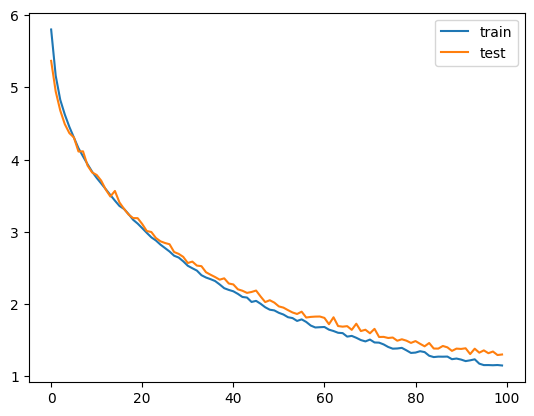

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


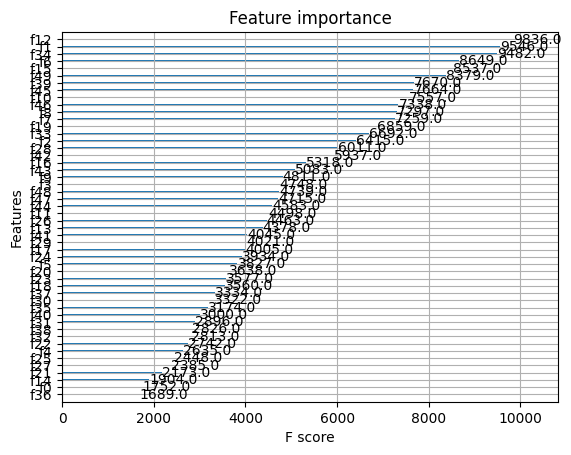

In [ ]:
xgb.plot_importance(xgb_model)
plt.show()


In [ ]:
model.save('lstm_model.h5')


In [ ]:
xgb_model.save_model('xgb_model.json')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Generating features for XGBoost model from LSTM model
X_test_features = feature_extractor.predict(X_test)

# Get predictions from XGBoost
y_pred = xgb_model.predict(X_test_features)

# Decode predictions and true labels
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:

behavior_labels = le.inverse_transform(np.arange(len(le.classes_)))
behavior_label_map = dict(enumerate(behavior_labels))

customer_ids = le_customer.inverse_transform(np.arange(len(le_customer.classes_)))
customer_id_map = dict(enumerate(customer_ids))


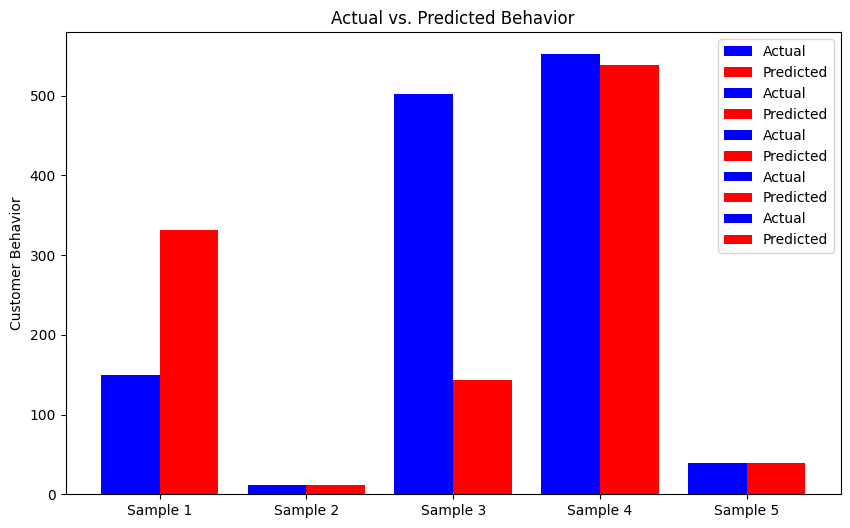

In [ ]:
import matplotlib.pyplot as plt

# Plotting actual vs. predicted values
fig, ax = plt.subplots(figsize=(10, 6))

for i, index in enumerate(sample_indices):
    ax.bar(i - 0.2, y_test_decoded[index], width=0.4, label='Actual', color='blue')
    ax.bar(i + 0.2, y_pred_decoded[index], width=0.4, label='Predicted', color='red')

ax.set_xticks(range(len(sample_indices)))
ax.set_xticklabels([f'Sample {i+1}' for i in range(len(sample_indices))])
ax.set_ylabel('Customer Behavior')
ax.set_title('Actual vs. Predicted Behavior')
ax.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Loading the models
lstm_model = load_model('lstm_model.h5')
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('xgb_model.json')

# Function to predict behavior
def predict_customer_behavior(customer_data):
    # Preprocess customer_data similarly to how X_test was processed
    # Generate features using the LSTM model
    features = feature_extractor.predict(customer_data)

    # Prediction using XGBoost model
    prediction = xgb_model.predict(features)

    return le.inverse_transform(prediction)




In [ ]:
# mapping from encoded labels to original labels
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))


In [ ]:

# Inverse transforming decoded labels to original Customer IDs
original_customer_ids = le_customer.inverse_transform(y_test_decoded)
predicted_customer_ids = le_customer.inverse_transform(y_pred_decoded)

sample_indices = np.random.choice(len(X_test), size=5, replace=False)

# DIsplay in dataframe
sample_data = pd.DataFrame({
    'CustomerID': original_customer_ids[sample_indices],    # Original Customer IDs
    'Actual Behavior': original_customer_ids[sample_indices],  # Original Customer IDs as actual labels
    'Predicted Behavior': predicted_customer_ids[sample_indices]  # Predicted Customer IDs
})

print(sample_data)




   CustomerID  Actual Behavior  Predicted Behavior
0     13410.0          13410.0             13410.0
1     16104.0          16104.0             14134.0
2     15983.0          15983.0             16168.0
3     13825.0          13825.0             13825.0
4     13668.0          13668.0             13114.0


In [ ]:
example_data = np.array([85123, 6, 15.30])
predicted_behavior = predict_customer_behavior(example_data)
print('Behaviour is most like behaviour of Customer with Customer ID:', predicted_customer_ids[predicted_behavior])


Predicted behaviour is most like behaviour of Customer with Customer ID: [16321.]
